# Базовое решение Задачи 1 "Изучение критической температуры сверхпроводников"

Данные о сверхпроводниках взяты из базы данных сверхпроводящих материалов, собранной Национальным институтом материаловедения Японии NIMS. 

Данные содержат сведения о **21 263 сверхпроводников**.

*   Тренировочный набор - **17010** строк.
*   Тестовый набор - **4253** строк.

Для каждого сверхпроводника в данных приведены полная химическая формула сверхпроводника, а также 8 основных химических свойств (абсолютное значение, среднее, взвешенное среднее и так далее): атомная масса, энергия ионизации, радиус атома, плотность, удельная теплота плавления, энергия сродства к электрону, теплопроводность, валентность.


## Считывание данных

In [1]:
!kaggle competitions download -c critical-temperature

In [2]:
!unzip critical-temperature.zip

In [3]:
# иморитирование всех необходимых библиотек
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
random_state = 42
np.random.seed(random_state)

In [5]:
# Считываем тренировочные данные
train = pd.read_csv("train.csv")
formula_train = pd.read_csv("formula_train.csv")

print(f"Train dataset shape: {train.shape}")
print(f"Train_formula dataset shape: {formula_train.shape}")

Train dataset shape: (17010, 82)
Train_formula dataset shape: (17010, 88)


In [6]:
# Считываем тестовые данные
test = pd.read_csv("test.csv")
formula_test = pd.read_csv("formula_test.csv")

print(f"Test dataset shape: {test.shape}")
print(f"Test_formula dataset shape: {formula_test.shape}")

Test dataset shape: (4253, 81)
Test_formula dataset shape: (4253, 87)


In [7]:
# Посмотрим как выглядят данные
train.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [8]:
formula_train.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


## Исследование данных

Прежде чем переходить к непосредственному построению модели, в первую очередь необходимо исследовать имеющихся у вас набор данных:
1. Какую задачу вы решаете (классификация, регрессия) и какая переменная является целевой?
2. Сколько переменных в данных и какого они типа?
3. Имеются ли в данных пропуски?

In [9]:
print("Number of missing values in train datasets:")
print(train.isna().sum())
print(formula_train.isna().sum())

Number of missing values in train datasets:
number_of_elements       0
mean_atomic_mass         0
wtd_mean_atomic_mass     0
gmean_atomic_mass        0
wtd_gmean_atomic_mass    0
                        ..
range_Valence            0
wtd_range_Valence        0
std_Valence              0
wtd_std_Valence          0
critical_temp            0
Length: 82, dtype: int64
H                0
He               0
Li               0
Be               0
B                0
                ..
Po               0
At               0
Rn               0
critical_temp    0
material         0
Length: 88, dtype: int64


In [10]:
print("Number of missing values in test datasets:")
print(test.isna().sum())
print(formula_test.isna().sum())

Number of missing values in test datasets:
number_of_elements       0
mean_atomic_mass         0
wtd_mean_atomic_mass     0
gmean_atomic_mass        0
wtd_gmean_atomic_mass    0
                        ..
wtd_entropy_Valence      0
range_Valence            0
wtd_range_Valence        0
std_Valence              0
wtd_std_Valence          0
Length: 81, dtype: int64
H           0
He          0
Li          0
Be          0
B           0
           ..
Bi          0
Po          0
At          0
Rn          0
material    0
Length: 87, dtype: int64


In [11]:
# Полные сведения о каждой переменной в тренировочном наборе данных
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17010 entries, 0 to 17009
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               17010 non-null  int64  
 1   mean_atomic_mass                 17010 non-null  float64
 2   wtd_mean_atomic_mass             17010 non-null  float64
 3   gmean_atomic_mass                17010 non-null  float64
 4   wtd_gmean_atomic_mass            17010 non-null  float64
 5   entropy_atomic_mass              17010 non-null  float64
 6   wtd_entropy_atomic_mass          17010 non-null  float64
 7   range_atomic_mass                17010 non-null  float64
 8   wtd_range_atomic_mass            17010 non-null  float64
 9   std_atomic_mass                  17010 non-null  float64
 10  wtd_std_atomic_mass              17010 non-null  float64
 11  mean_fie                         17010 non-null  float64
 12  wtd_mean_fie      

Во всех столбцах обоих датасетов (train и formula_train) количество пропущенных значений равно 0.
Можно безопасно продолжать обучение моделей без риска ошибок, связанных с NaN.

## Предобработка данных

### **Тренировочные данные.**

В данной задаче у нас имеются два датасета для тренировки и для теста, для удобства сформируем один DataFrame.

Так как колонка с целевой переменной имеется в обоих датасетах, удалим её из одного, чтобы не дублировать.

In [12]:
formula_train = formula_train.drop(columns=["critical_temp"])

train_full = pd.concat([train, formula_train], axis=1)

print(f"Full Train dataset shape: {train_full.shape}")

Full Train dataset shape: (17010, 169)


In [13]:
# Удалим из данных ненужную колонку 'material'
train_full.drop(columns=["material"], inplace=True)

In [14]:
train_full.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


In [15]:
# Выделим из набора данных вектор признаков и вектор ответов
X = train_full.drop(columns=["critical_temp"])
y = train_full["critical_temp"]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (17010, 167)
Target shape: (17010,)


### **Тестовые данные.**

Обработаем аналогичным образом тестовые данные.

In [16]:
test_full = pd.concat([test, formula_test], axis=1)

print(f"Full Test dataset shape: {test_full.shape}")

Full Test dataset shape: (4253, 168)


In [17]:
# Удалим из данных ненужную колонку 'material'
test_full.drop(columns=["material"], inplace=True)

## Обучение модели

Обучение нескольких моделей, их сравнение.

In [18]:
# Разделение на признаки и целевую переменную
X = train_full.drop("critical_temp", axis=1)
y = train_full["critical_temp"]

In [19]:
# Масштабирование признаков (стандартизация)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Предварительное разделение на обучение и проверку (для локальной оценки)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=random_state)

In [21]:
# Обучение базовых моделей линейной регрессии
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1, random_state=random_state),
    "Lasso Regression": Lasso(alpha=1, random_state=random_state)
}

for name, model in models.items():
    print(f"\nМодель: {name}\n")
    # Обучаем модель
    model.fit(X_train, y_train)

    # Оцениваем качество на проверочной части
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f"Средняя квадратичная ошибка (MSE): {mse:.4f}")
    print(f"Коэффициент детерминации (R^2): {r2:.4f}")


Модель: Linear Regression

Средняя квадратичная ошибка (MSE): 280.1071
Коэффициент детерминации (R^2): 0.7538

Модель: Ridge Regression

Средняя квадратичная ошибка (MSE): 280.0206
Коэффициент детерминации (R^2): 0.7539

Модель: Lasso Regression

Средняя квадратичная ошибка (MSE): 356.2480
Коэффициент детерминации (R^2): 0.6869


#### Линейная регрессия
Среднее квадратичное отклонение между истинным и предсказанным значением температуры — около 16.7(так как sqrt(280) = 16.7).
75.4% того, почему critical_temp принимает разные значения — можно объяснить линейной комбинацией признаков (атомных масс, валентностей и т.д.).

#### Гребневая регрессия
По сравнению с линейной регрессией MSE чуть меньше (280.02 вместо 280.11), а R^2 чуть выше (0.7539 вместо 0.7538)
Ошибка в предсказаниях снизилась примерно на 0.09 единиц MSE, что незначительно, но в правильную сторону.

#### Лассо-регрессия
MSE и R^2 выше, чем у двух других моделей. Модель объясняет только ~68.7% дисперсии
Это худший результат из трёх.

In [23]:
# Настройка гиперпараметров для Ridge
param_grid_ridge = {"alpha": [0.01, 0.1, 1, 10]}
grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5, scoring="neg_mean_squared_error")
grid_search_ridge.fit(X_train, y_train)
best_alpha_ridge = grid_search_ridge.best_params_["alpha"]
print(f"\nЛучшая альфа для Ridge: {best_alpha_ridge}")


Лучшая альфа для Ridge: 10


In [24]:
# Настройка гиперпараметров для Lasso
param_grid_lasso = {"alpha": [0.01, 0.1, 1, 10], "max_iter": [10000]}
grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5, scoring="neg_mean_squared_error")
grid_search_lasso.fit(X_train, y_train)
best_alpha_lasso = grid_search_lasso.best_params_["alpha"]
print(f"\nЛучшая альфа для Lasso: {best_alpha_lasso}")


Лучшая альфа для Lasso: 1


In [25]:
# Повторное обучение лучших моделей с подобранными параметрами
final_models = {
    "Final Ridge": Ridge(alpha=best_alpha_ridge),
    "Final Lasso": Lasso(alpha=best_alpha_lasso)
}

for name, model in final_models.items():
    print(f"\nФинальная модель: {name}\n")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f"Модель {name}: MSE={mse:.4f}, R²={r2:.4f}")


Финальная модель: Final Ridge

Модель Final Ridge: MSE=281.4874, R²=0.7526

Финальная модель: Final Lasso

Модель Final Lasso: MSE=356.2480, R²=0.6869


После подбора оптимальных гиперпараметров (alpha) с помощью GridSearchCV, модели были переобучены на обучающей части данных (X_train, y_train), и их качество оценено на валидационной выборке (X_val, y_val).

#### Гребневая регрессия
Средняя квадратичная ошибка немного выше, чем у базового Ridge с alpha=1 (было 280.02), но очень близко.
R^2 = 0.7526, а в базовом варианте было 0.7539. Небольшое падение R, скорее всего, связано с малой выборкой или наличием шума.

#### Лассо регрессия
MSE значительно выше, чем у Ridge, но R^2 ниже.

## Финальное предсказание

In [26]:
# Применяем стандартизацию к тестовым данным
X_test_scaled = scaler.transform(test_full)

# Используем лучшую модель для предсказания на тестовом наборе
best_model = Ridge(alpha=best_alpha_ridge)
best_model.fit(X_scaled, y)
predictions = best_model.predict(X_test_scaled)

In [27]:
# Сохранение результата
result = pd.DataFrame({"critical_temp": predictions})

result.to_csv("prediction_results.csv", index=True, index_label="index")

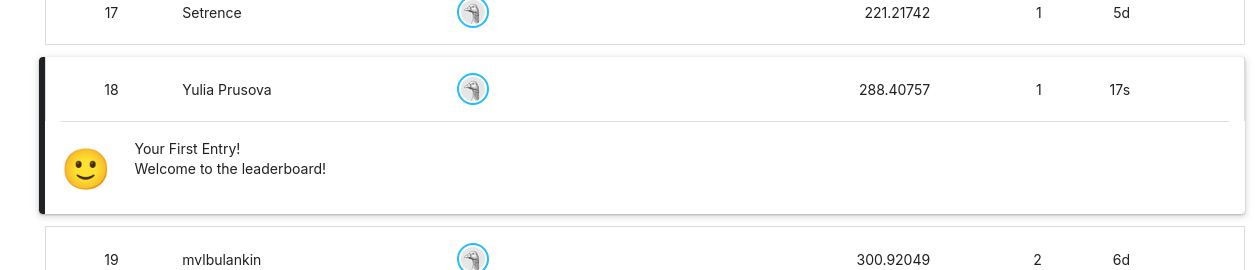